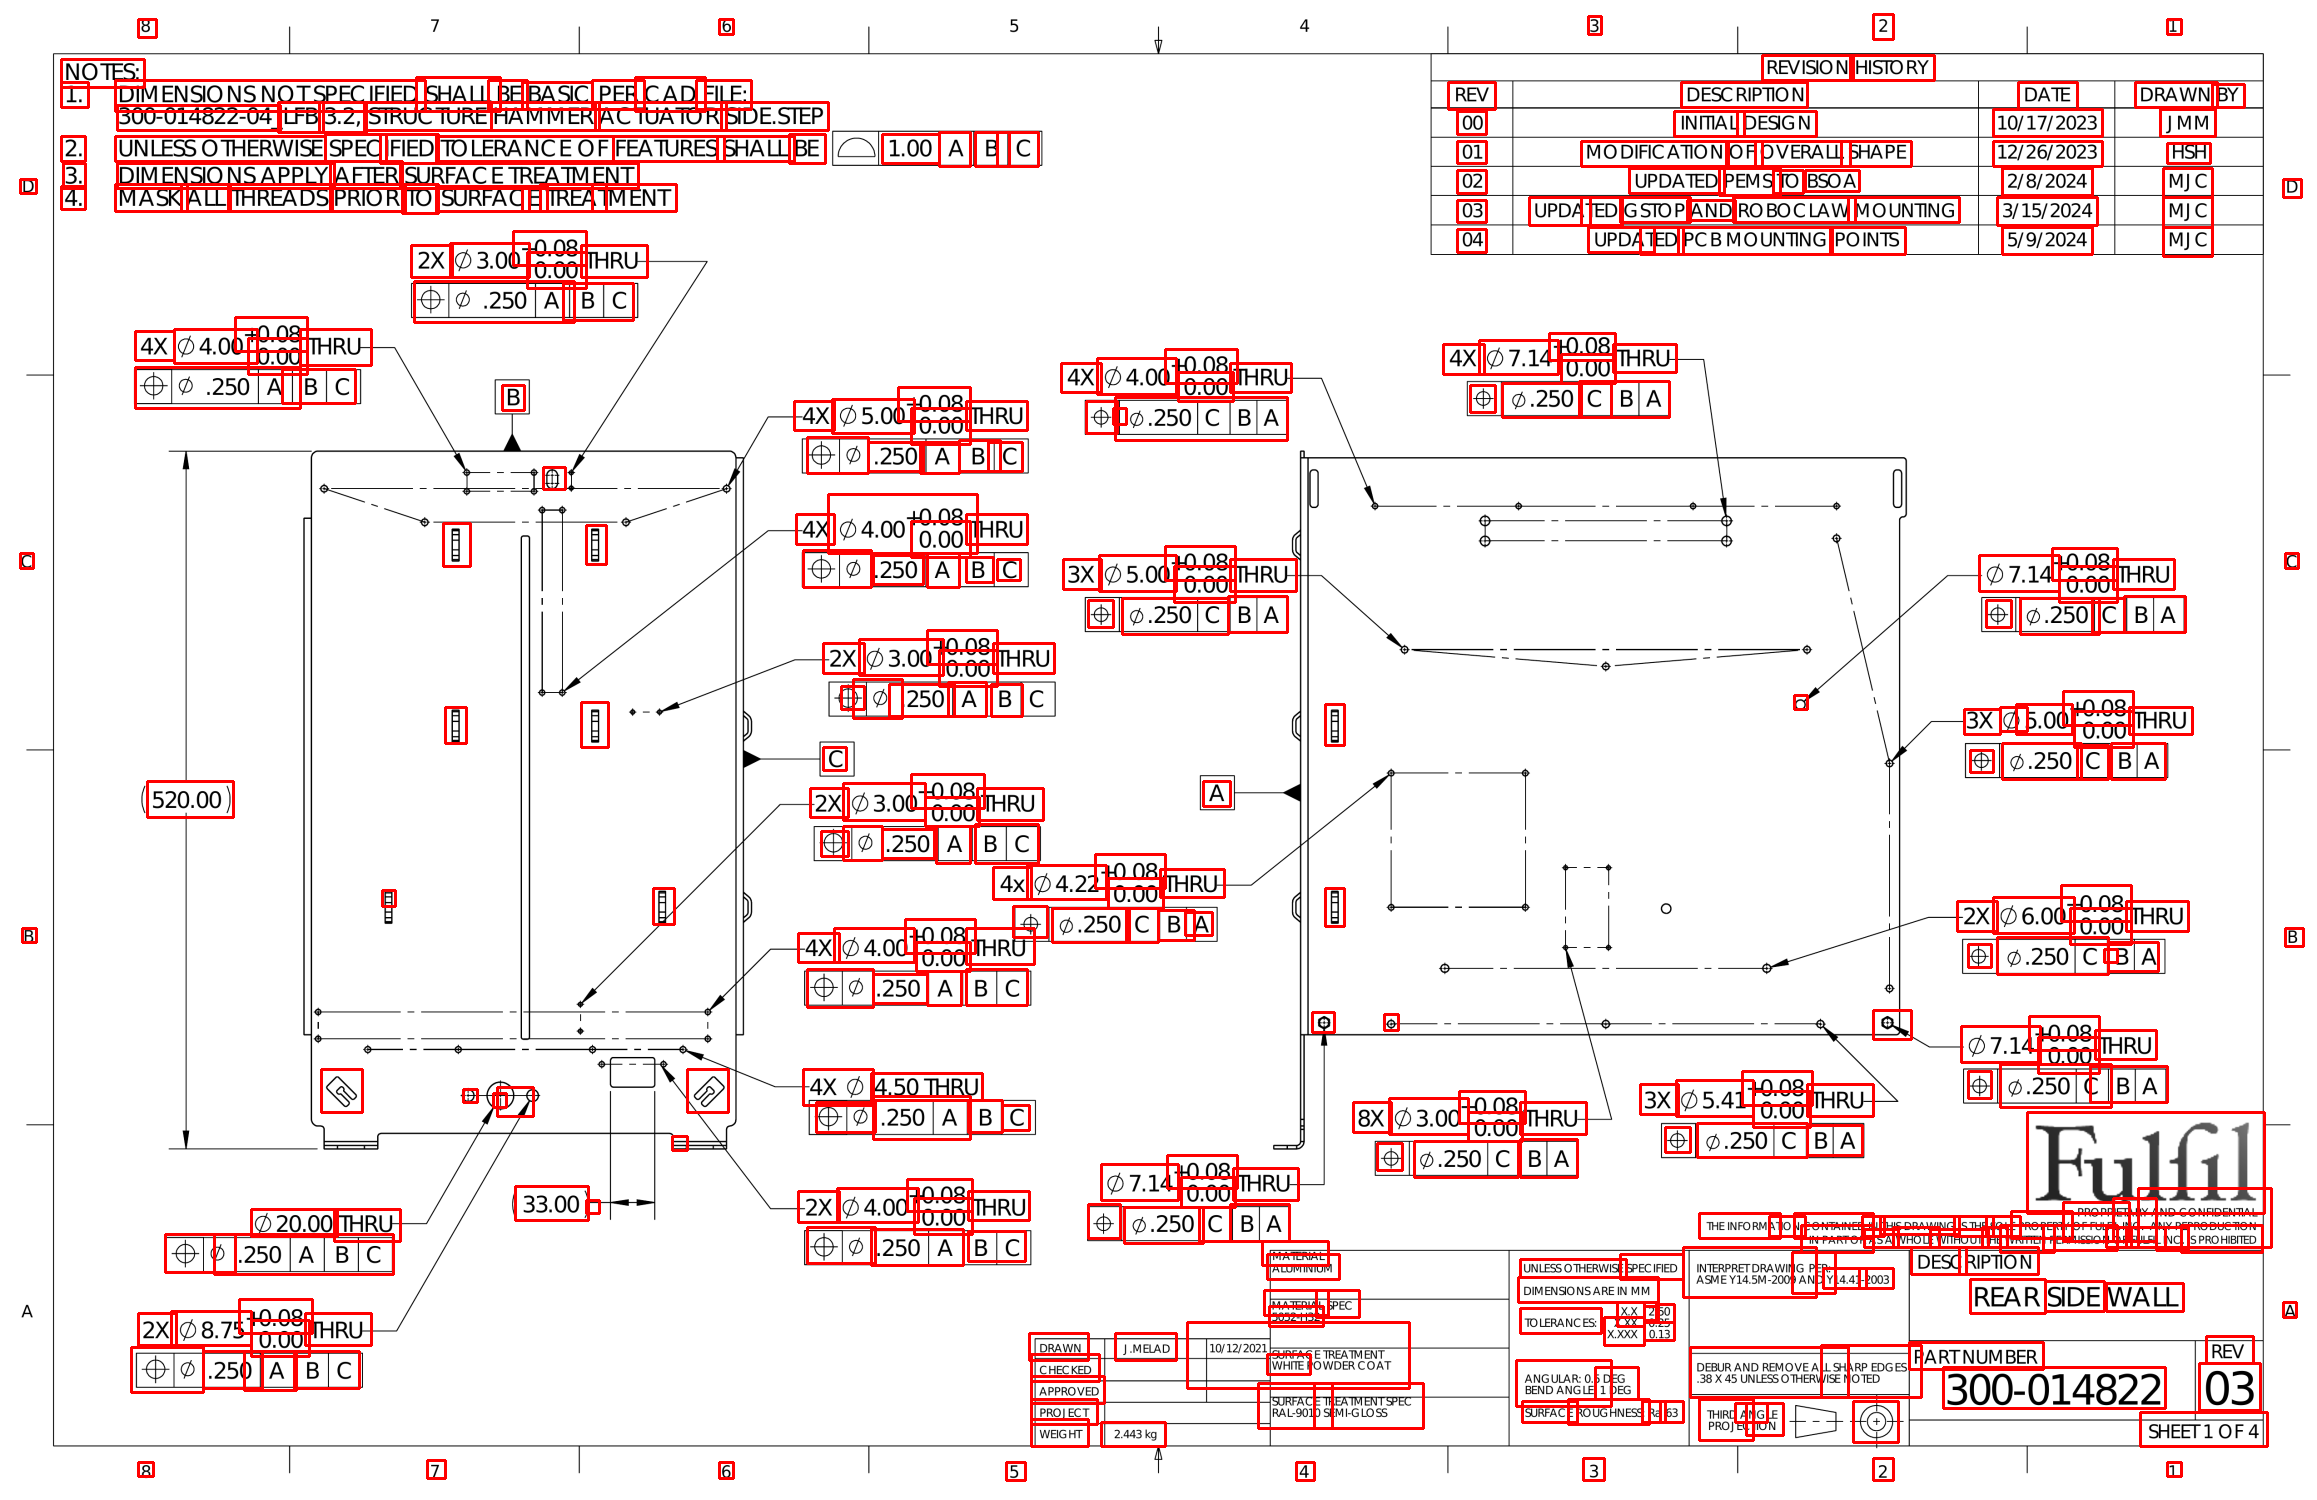

In [5]:
import math
from glob import glob
import os

import cv2
import numpy as np
from PIL import Image
from pdf2image import convert_from_path
from imutils import resize
from sklearn.metrics import euclidean_distances
from tqdm import tqdm
from scoring import *
from border_and_title import *

# f = "../../data/original/Ugly/10.pdf"
# f = "../../data/original/Ugly/2.pdf"
# f = "../../data/original/Ugly/3.pdf"
# f = "../../data/original/Ugly/000.895.652.pdf"
# f = "../../data/original/Good/300-014823.pdf"
f = "../../data/original/Good/300-014822.pdf"

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
color = (255, 0, 0)
thickness = 2

pages = convert_from_path(f, dpi=300)
img = np.array(pages[0])
img = im_resize(img)
img_comp = img.copy()

im_h, im_w, _ = img.shape
sorted_indices, contours, hierarchy_area = detect_objects(img)
title_contours, line_90, data = detect_probable_title_sections(img, return_states=True)
ocr_result = data["ocr_result"]
mask = data["mask"]
inner_border_lines = data["inner_border_lines"]  #  0: Bottom, 1: Top, 2: Right, 3: Left
words = process_text(ocr_result, im_h, im_w)

for idx, row in words.iterrows():
    bx1, by1, bx2, by2 = row[["x1", "y1", "x2", "y2"]].astype(int)
    cv2.rectangle(img_comp, (bx1, by1), (bx2, by2), (255, 0, 0), 2)

Image.fromarray(img_comp)

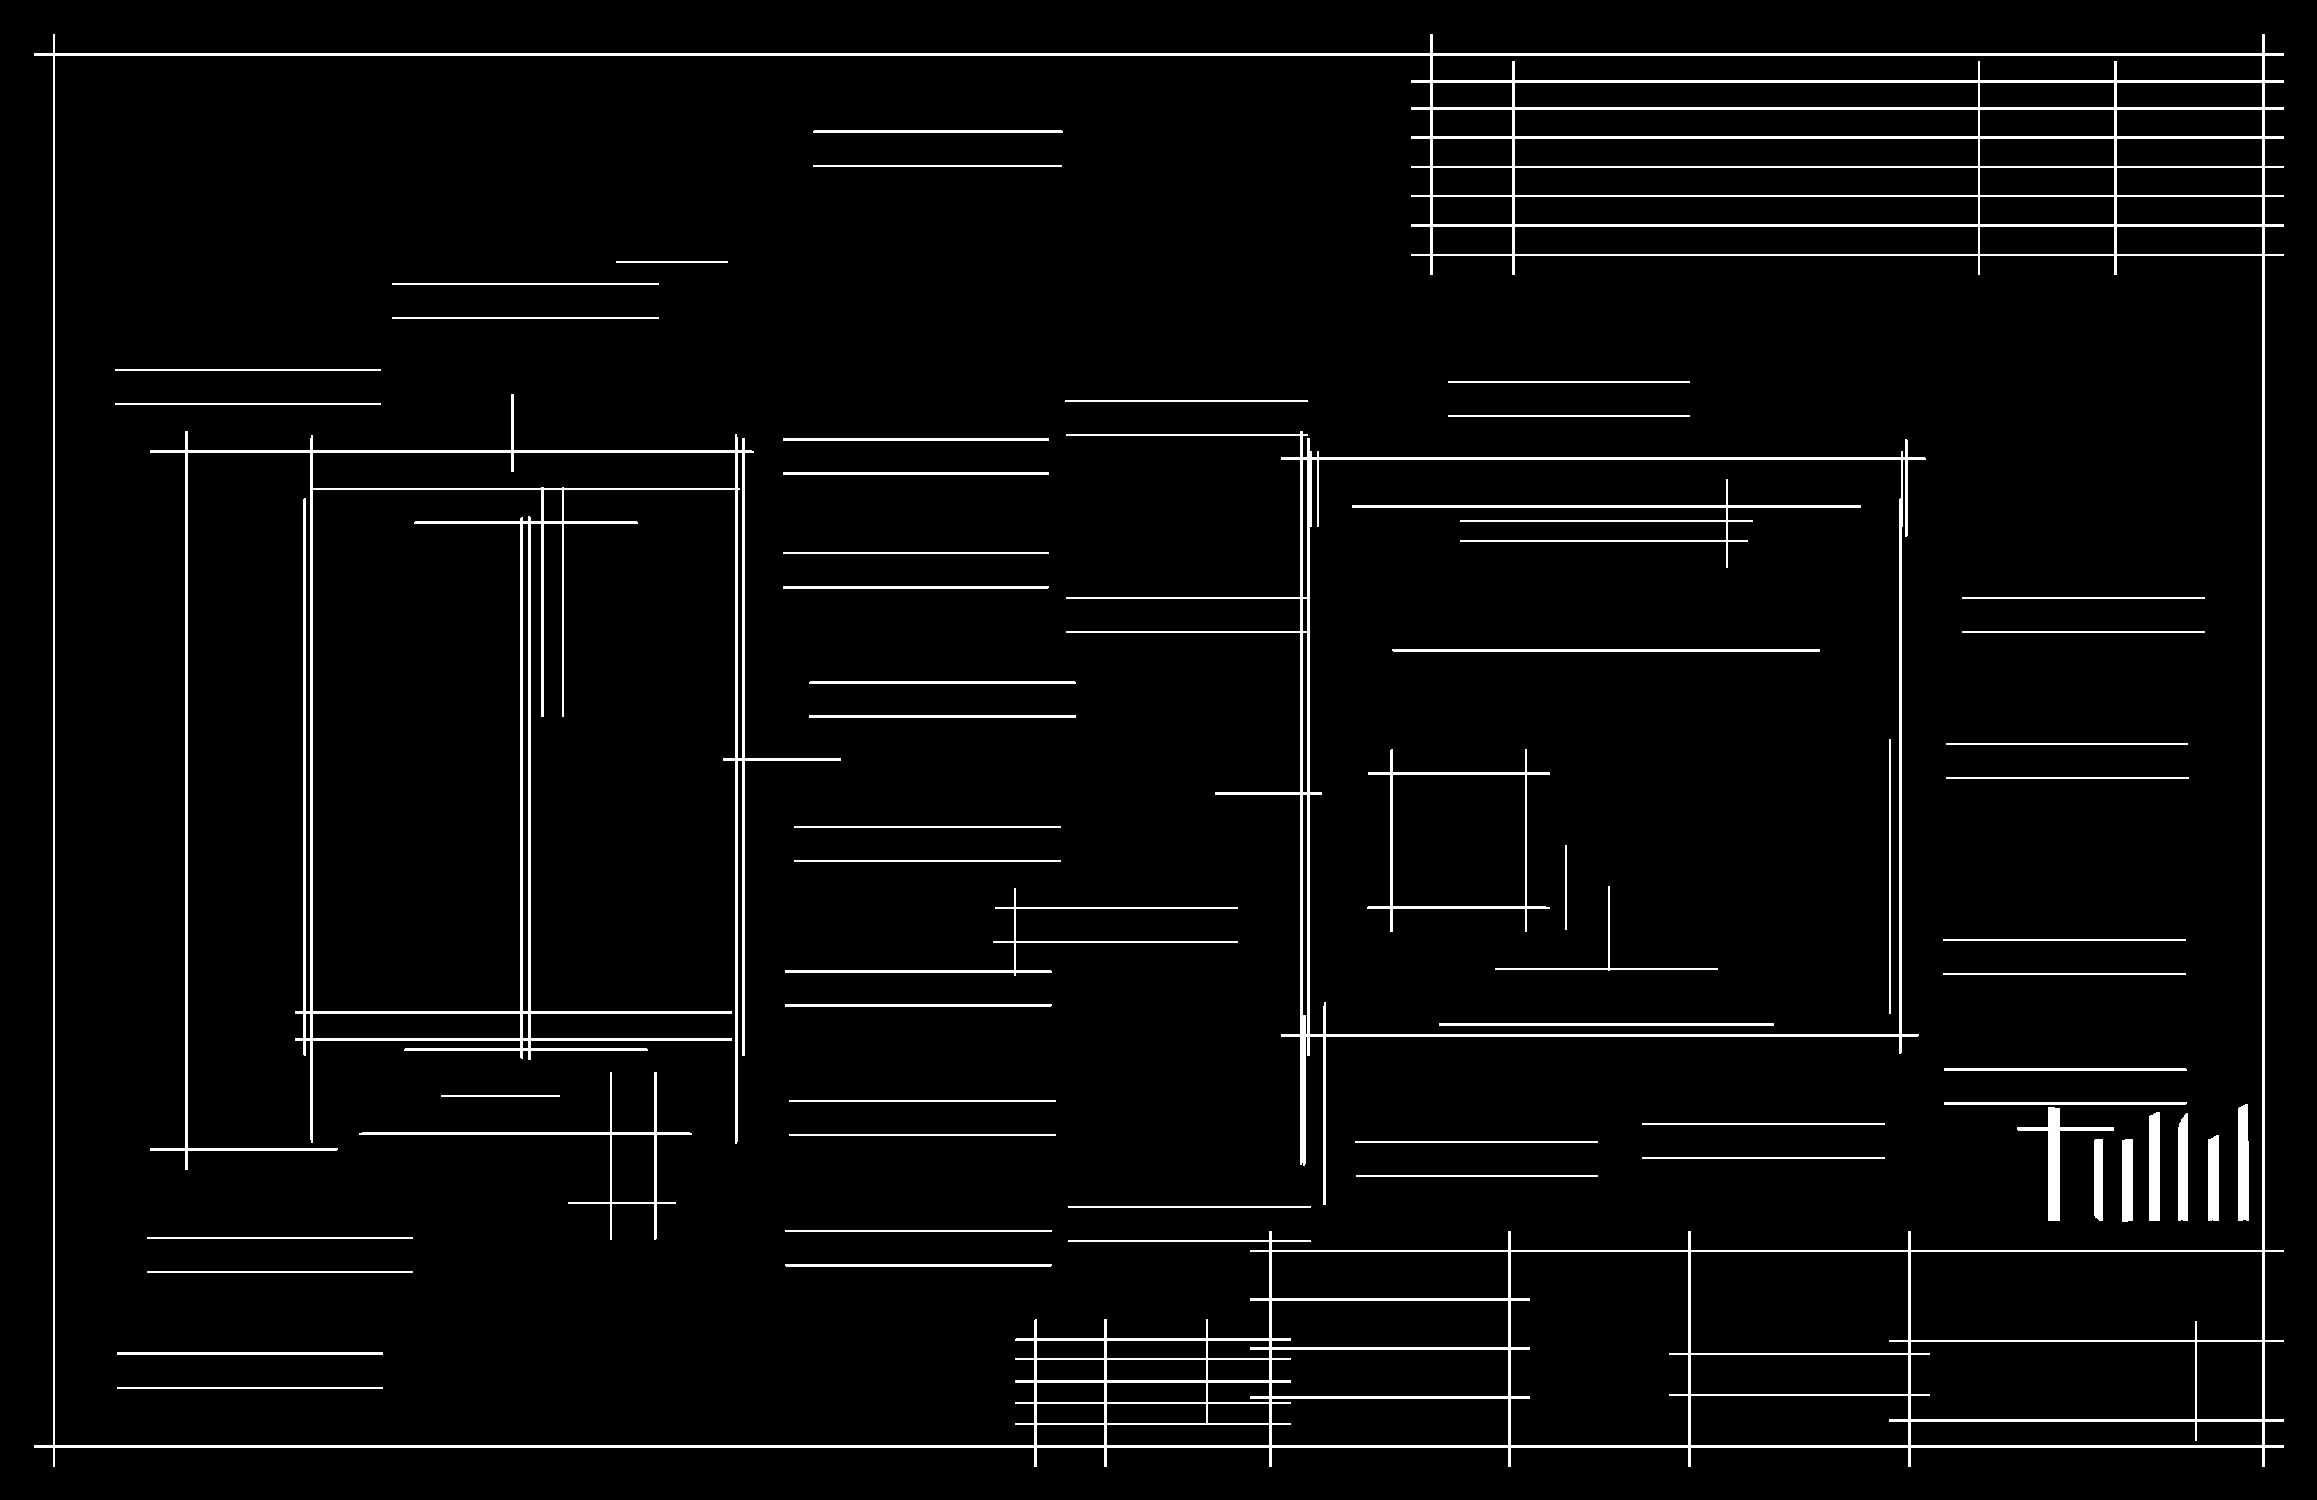

In [6]:
Image.fromarray(mask)

In [7]:
im_h, im_w, _ = img.shape
# 362
# 365
# 366
# 367
# 368
# 369
# 370
# 371
# 372
# 374
# 375
word = words.iloc[348]
bx1, by1, bx2, by2 = word[["x1", "y1", "x2", "y2"]].astype(int)

straight_lines = cv2.HoughLinesP(mask, 1, np.pi / 180, 15, np.array([]), 50, 10)
straight_lines = straight_lines.squeeze(axis=1)

horizontal_lines = []
vertical_lines = []

for (x1, y1, x2, y2) in straight_lines:
    if abs(y1 - y2) <= 5:
        horizontal_lines.append((x1, y1, x2, y2))
    elif abs(x1 - x2) <= 5:
        vertical_lines.append((x1, y1, x2, y2))

horizontal_lines = np.array(horizontal_lines)
vertical_lines = np.array(vertical_lines)
t_dist = 200

horizontal_lines = np.stack([
    np.minimum(horizontal_lines[:, 0], horizontal_lines[:, 2]),
    np.minimum(horizontal_lines[:, 1], horizontal_lines[:, 3]),
    np.maximum(horizontal_lines[:, 0], horizontal_lines[:, 2]),
    np.maximum(horizontal_lines[:, 1], horizontal_lines[:, 3])
], axis=1)

vertical_lines = np.stack([
    np.minimum(vertical_lines[:, 0], vertical_lines[:, 2]),
    np.minimum(vertical_lines[:, 1], vertical_lines[:, 3]),
    np.maximum(vertical_lines[:, 0], vertical_lines[:, 2]),
    np.maximum(vertical_lines[:, 1], vertical_lines[:, 3])
], axis=1)

horizontal_lines

array([[  34,   53, 2283,   53],
       [  34, 1447, 2283, 1447],
       [  34, 1445, 2283, 1445],
       [  34, 1446, 2283, 1446],
       [  34,   54, 2283,   54],
       [  34,   55, 2283,   55],
       [1411,  224, 2283,  224],
       [1281,  457, 1924,  457],
       [1411,  107, 2283,  107],
       [1250, 1250, 2283, 1250],
       [1250, 1251, 2283, 1251],
       [1411,  254, 2283,  254],
       [1411,  166, 2283,  166],
       [1281, 1035, 1918, 1035],
       [1411,  225, 2283,  225],
       [1411,  137, 2283,  137],
       [1411,  138, 2283,  138],
       [ 150,  451,  753,  451],
       [1281,  459, 1925,  459],
       [ 117, 1354,  382, 1354],
       [1411,  108, 2283,  108],
       [1411,  226, 2283,  226],
       [1411,  255, 2283,  255],
       [1411,  109, 2283,  109],
       [1411,  195, 2283,  195],
       [1411,   81, 2283,   81],
       [1411,  196, 2283,  196],
       [1411,  136, 2283,  136],
       [1411,   82, 2283,   82],
       [1015, 1340, 1290, 1340],
       [14

In [14]:
vertical_lines

array([[2264,   34, 2264, 1466],
       [  54,   34,   54, 1466],
       [  53,   34,   53, 1466],
       [2263,   34, 2263, 1466],
       [ 744,  438,  744, 1055],
       [ 312,  435,  312, 1150],
       [ 311,  435,  311, 1150],
       [ 185,  431,  185, 1169],
       [ 742,  438,  742, 1055],
       [ 187,  431,  187, 1169],
       [ 736,  434,  736, 1143],
       [1307,  434, 1307, 1055],
       [ 310,  438,  310, 1150],
       [ 186,  431,  186, 1169],
       [ 529,  516,  529, 1059],
       [ 743,  438,  743, 1055],
       [2262,   34, 2262, 1466],
       [ 304,  498,  304, 1055],
       [ 528,  516,  528, 1059],
       [ 737,  437,  737, 1141],
       [ 303,  499,  303, 1054],
       [ 520,  518,  520, 1057],
       [1301,  431, 1301, 1164],
       [1309,  438, 1309, 1055],
       [ 735,  434,  735, 1143],
       [ 530,  517,  530, 1059],
       [1302,  431, 1302, 1162],
       [ 521,  517,  521, 1058],
       [1300,  431, 1300, 1164],
       [ 305,  498,  305, 1055],
       [ 5

In [10]:
x = int((bx1 + bx2) / 2)
y = int((by1 + by2) / 2)

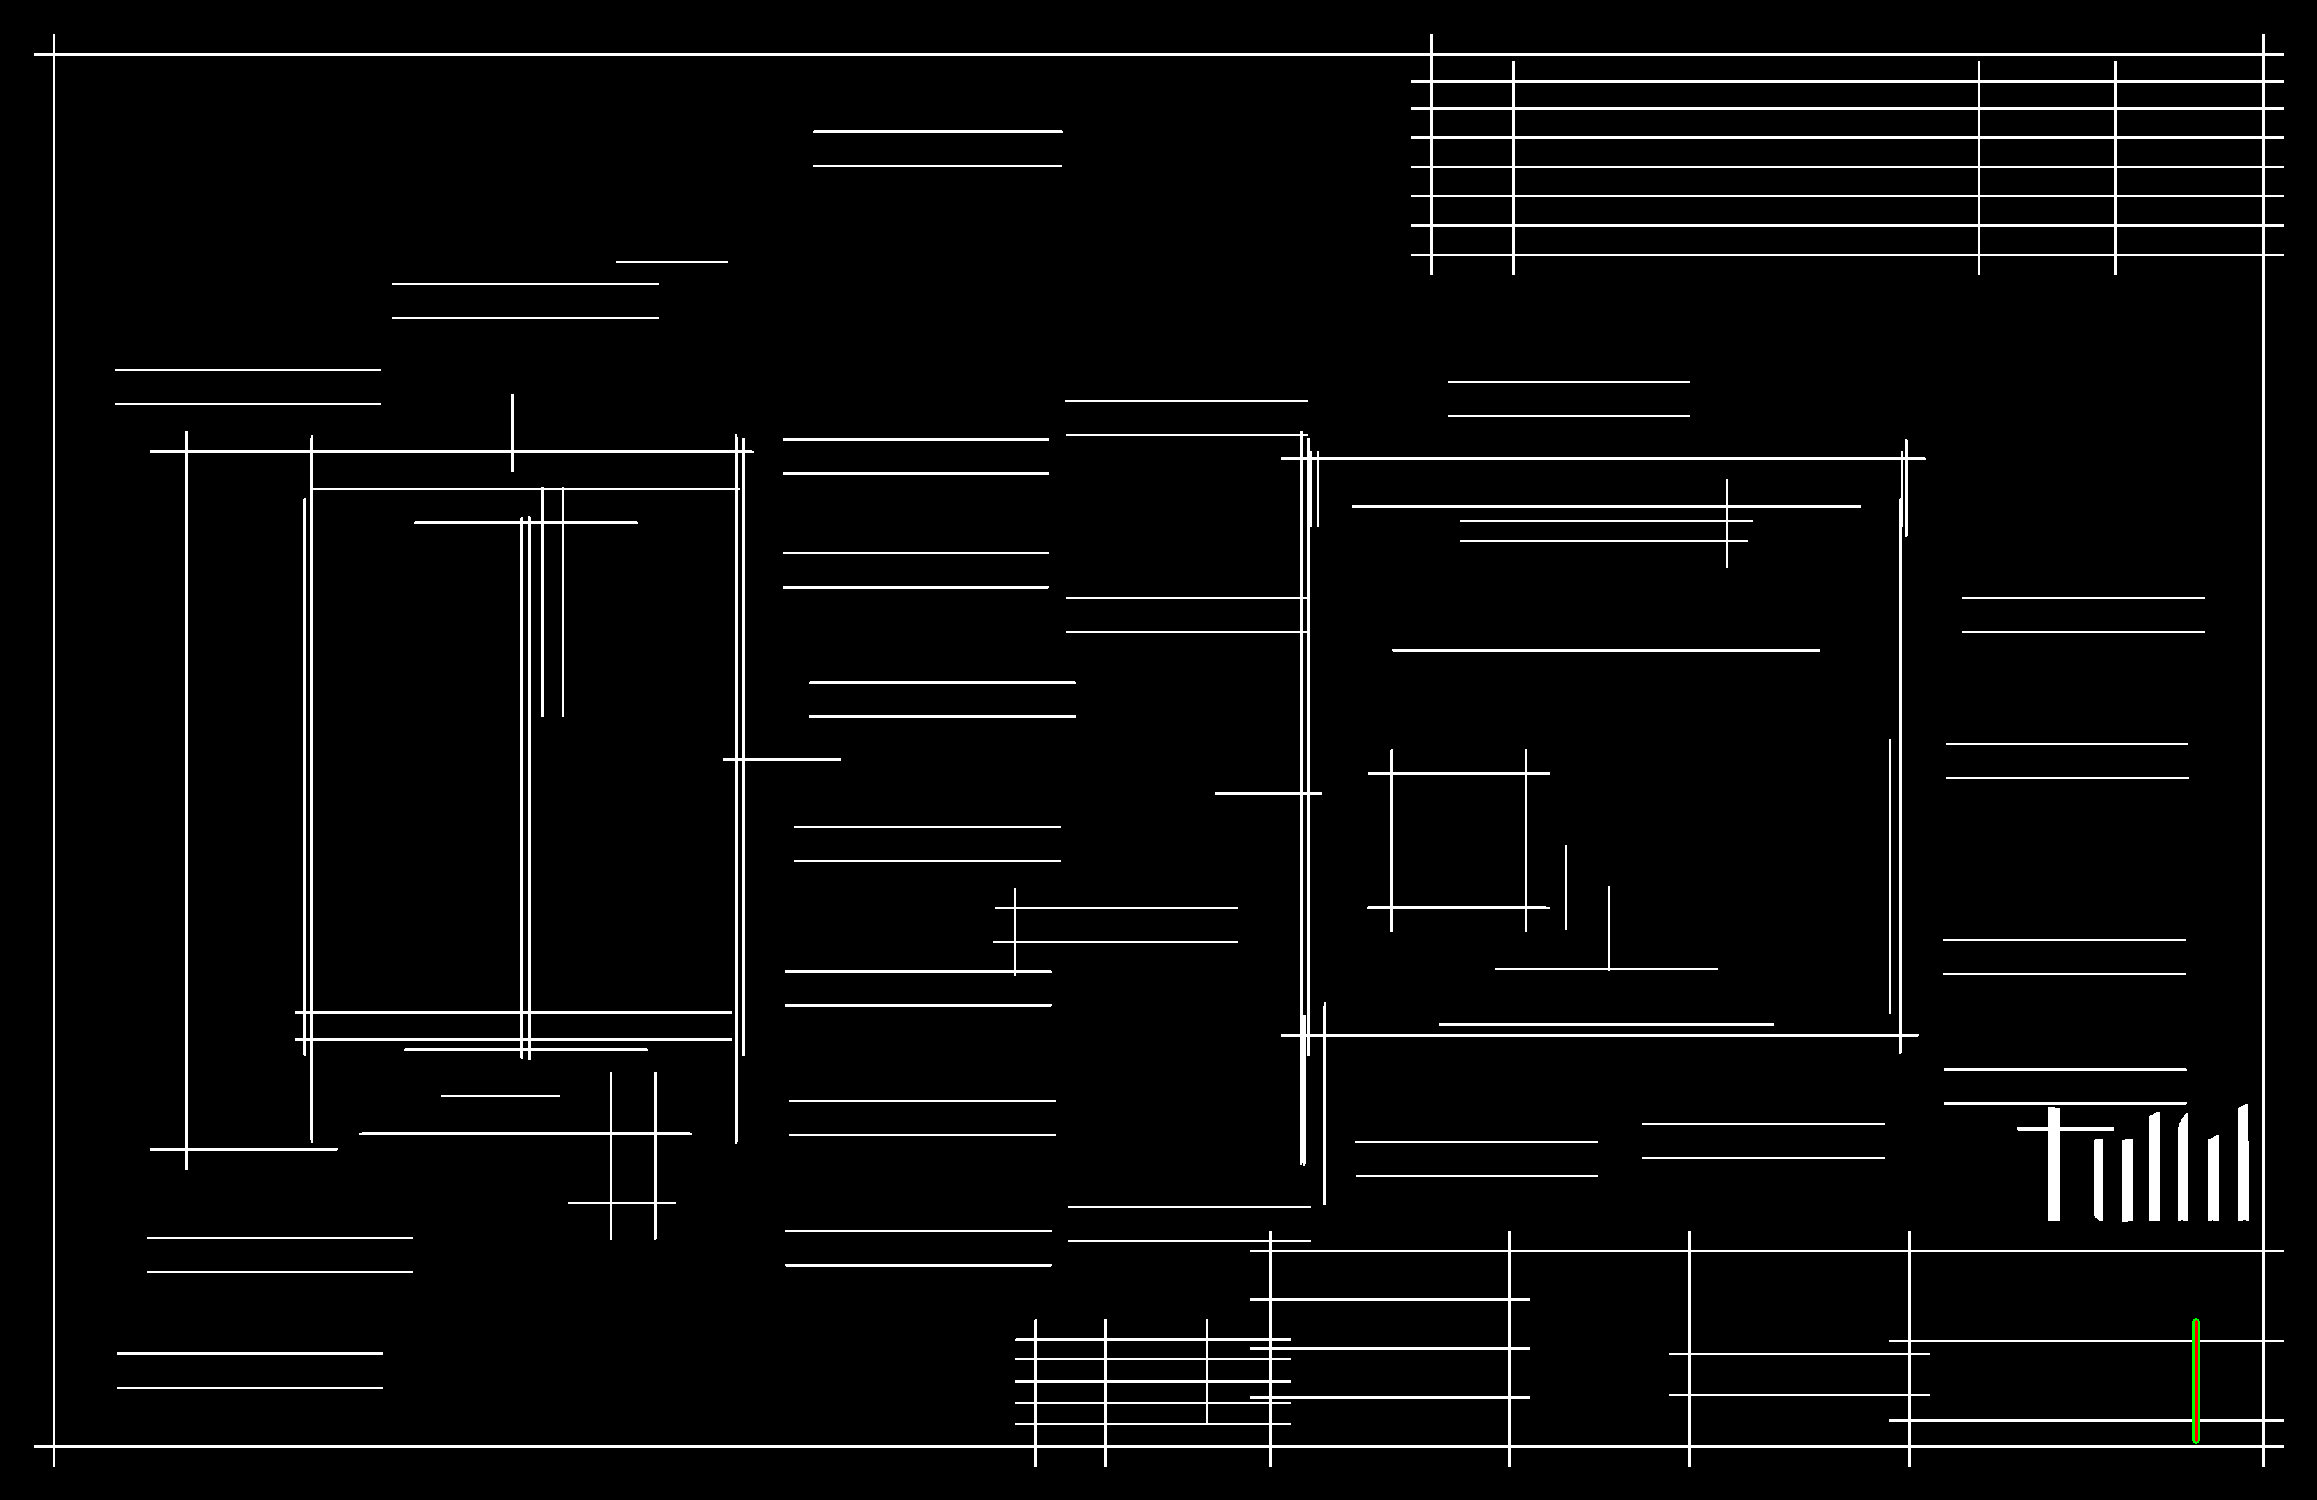

In [29]:
img_comp = mask.copy()
img_comp = cv2.cvtColor(img_comp, cv2.COLOR_GRAY2BGR)

left = vertical_lines[(vertical_lines[:, 0] < bx1) & (vertical_lines[:, 0] > (bx1 - t_dist)) & (vertical_lines[:, 1] < y) & (vertical_lines[:, 3] > y)]
# left = vertical_lines[(vertical_lines[:, 0] < bx1) & (vertical_lines[:, 0] > (bx1 - t_dist)) & (vertical_lines[:, 1] > by1) & (vertical_lines[:, 3] < by2)]

for (x1, y1, x2, y2) in left:
    cv2.line(img_comp, (x1, y1), (x2, y2), (0, 255, 0), 5)

left = left[left[:, 0].argmax()]
x1, y1, x2, y2 = left
cv2.line(img_comp, (x1, y1), (x2, y2), (255, 0, 0), 2)

Image.fromarray(img_comp)

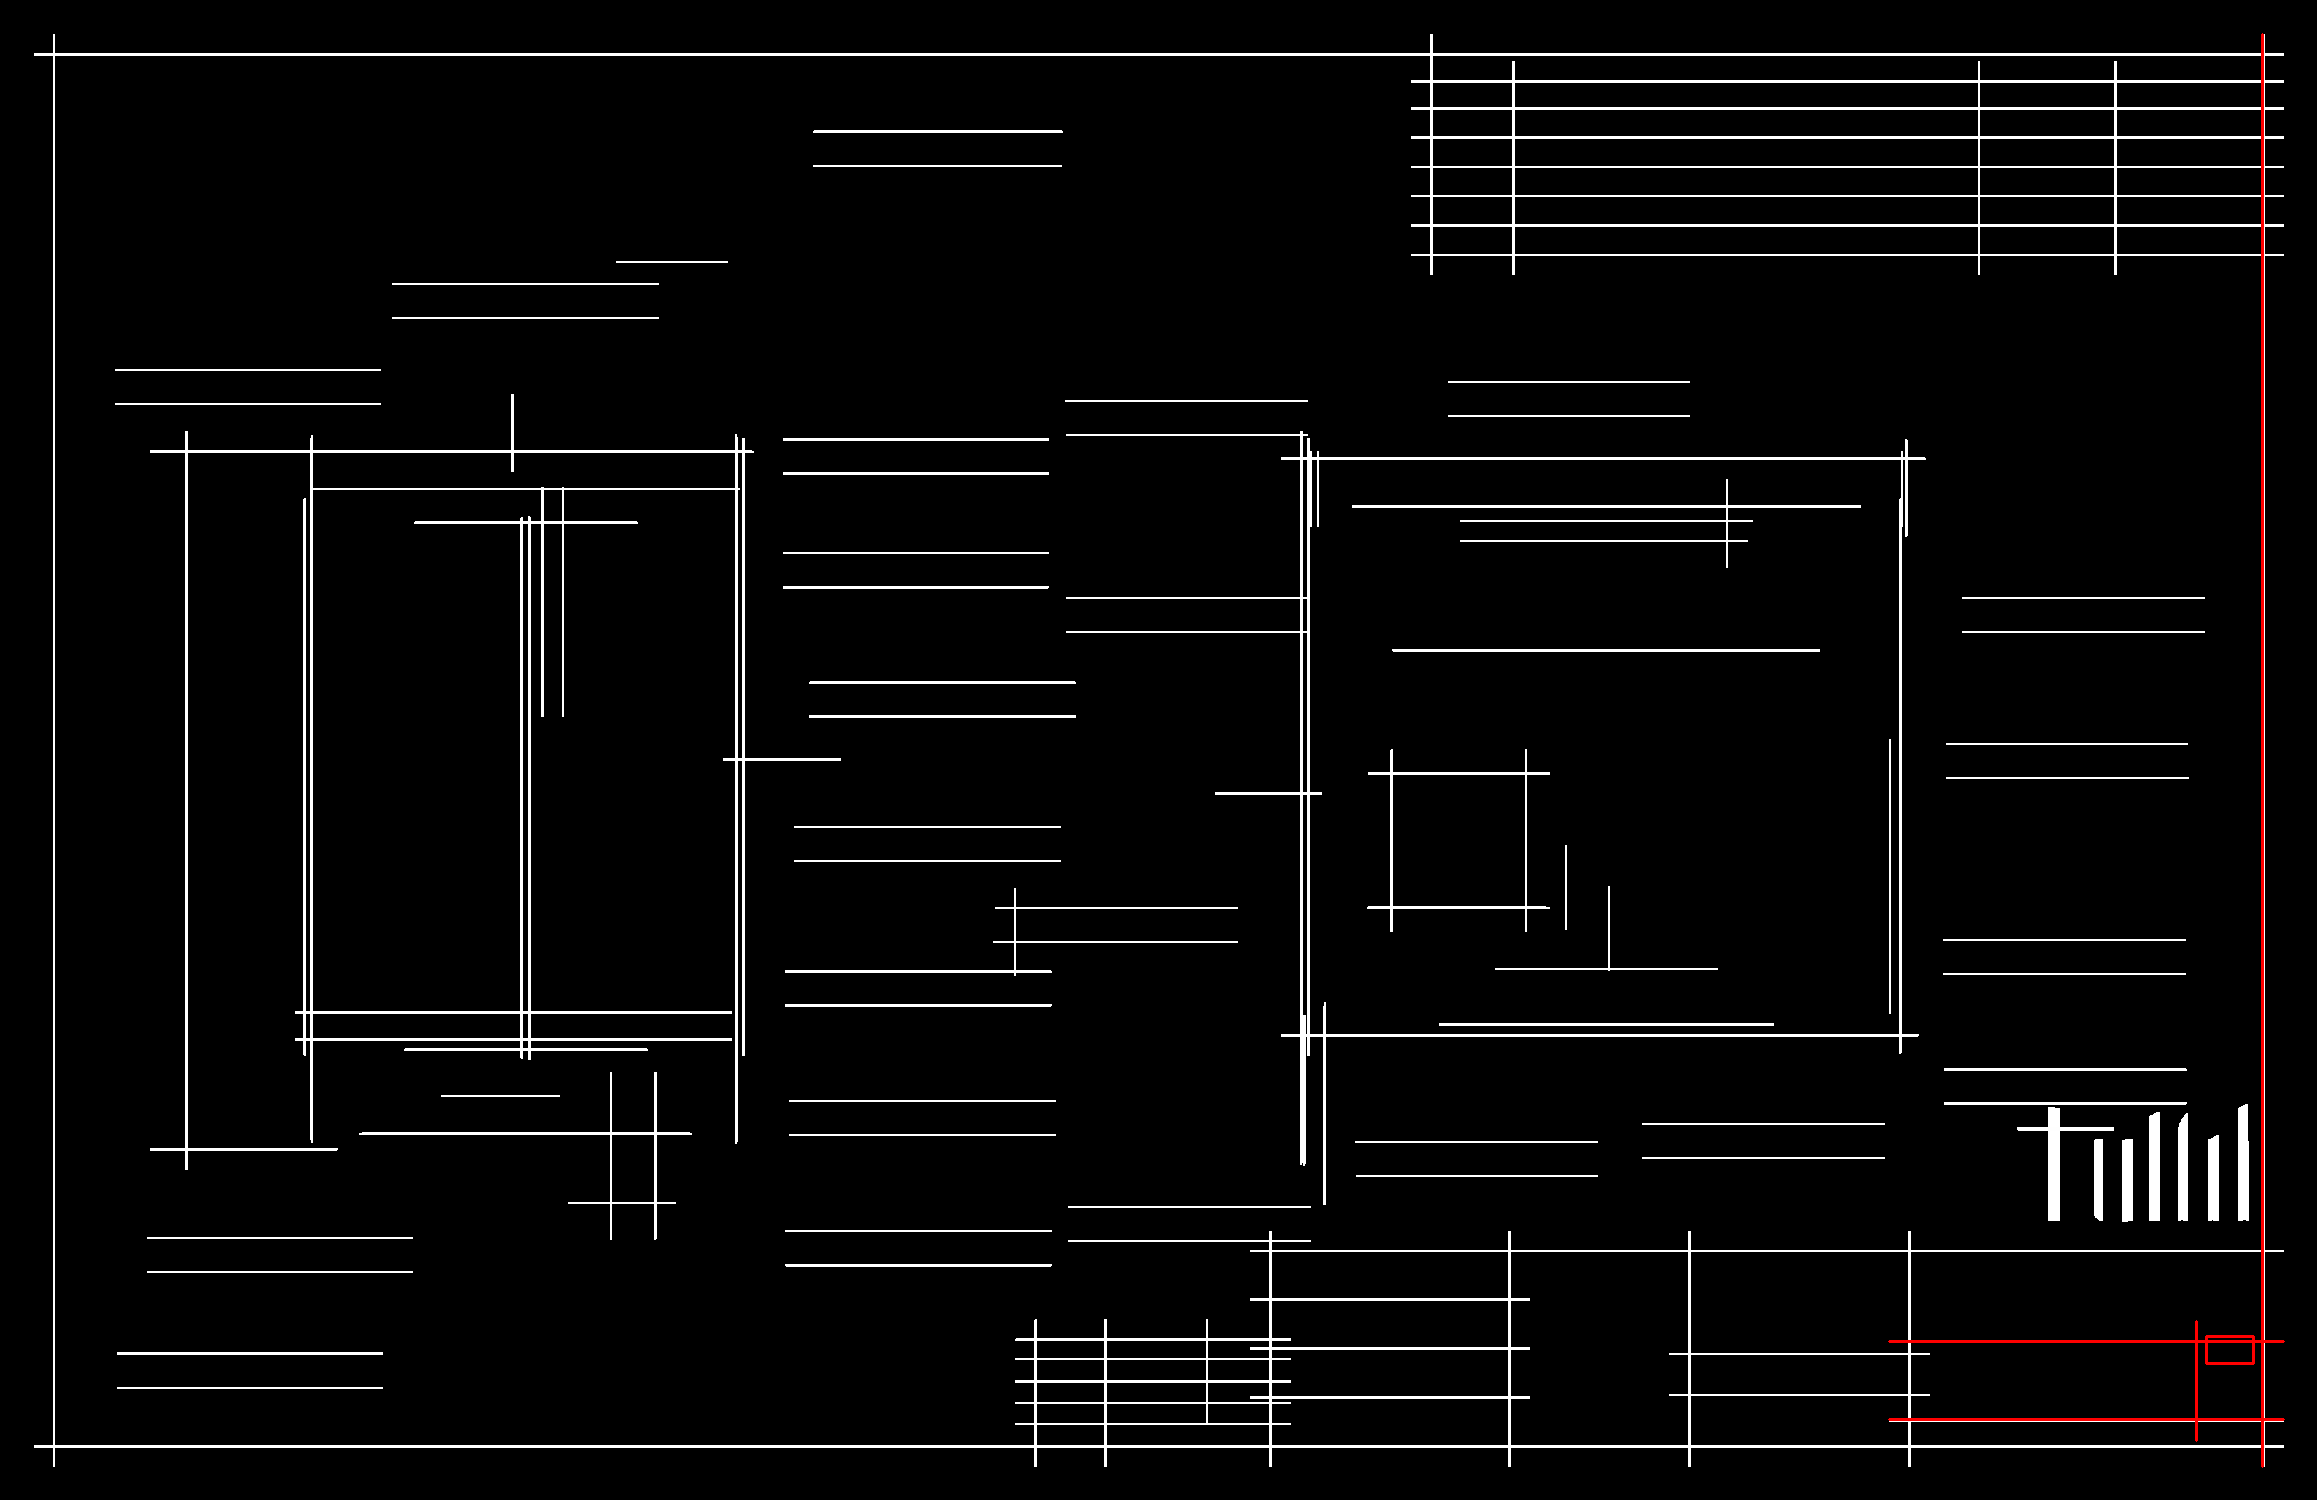

In [30]:
img_comp = mask.copy()
img_comp = cv2.cvtColor(img_comp, cv2.COLOR_GRAY2BGR)

top = horizontal_lines[(horizontal_lines[:, 1] < y) & (horizontal_lines[:, 1] > (y - t_dist)) & (horizontal_lines[:, 0] < x) & (horizontal_lines[:, 2] > x)]
top = top[top[:, 1].argmax()]

bottom = horizontal_lines[(horizontal_lines[:, 1] > y) & (horizontal_lines[:, 1] < (y + t_dist)) & (horizontal_lines[:, 0] < x) & (horizontal_lines[:, 2] > x)]
bottom = bottom[bottom[:, 0].argmax()]

right = vertical_lines[(vertical_lines[:, 0] > x) & (vertical_lines[:, 0] < (x + t_dist)) & (vertical_lines[:, 1] < y) & (vertical_lines[:, 3] > y)]
right = right[right[:, 0].argmin()]

left = vertical_lines[(vertical_lines[:, 0] < bx1) & (vertical_lines[:, 0] > (bx1 - t_dist)) & (vertical_lines[:, 1] < y) & (vertical_lines[:, 3] > y)]
left = left[left[:, 0].argmax()]

word_lines = np.array([left, top, right, bottom])

bx1, by1, bx2, by2 = word[["x1", "y1", "x2", "y2"]].astype(int)
cv2.rectangle(img_comp, (bx1, by1), (bx2, by2), (255, 0, 0), 2)

for (x1, y1, x2, y2) in word_lines:
    cv2.line(img_comp, (x1, y1), (x2, y2), (255, 0, 0), 2)

Image.fromarray(img_comp)